In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn import metrics
import random

In [135]:
data = pd.read_csv("encoded_data.csv")
data

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,degree_percentage,work_experience,emp_test_percentage,specialisation,mba_percent,status,hsc_subject_Arts,hsc_subject_Commerce,hsc_subject_Science,undergrad_degree_Comm&Mgmt,undergrad_degree_Others,undergrad_degree_Sci&Tech
0,1,67.00,0,91.00,0,58.00,0,55.0,0,58.80,1,0,1,0,0,0,1
1,1,79.33,1,78.33,0,77.48,1,86.5,1,66.28,1,0,0,1,0,0,1
2,1,65.00,1,68.00,1,64.00,0,75.0,1,57.80,1,1,0,0,1,0,0
3,1,56.00,1,52.00,1,52.00,0,66.0,0,59.43,0,0,0,1,0,0,1
4,1,85.80,1,73.60,1,73.30,0,96.8,1,55.50,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,1,80.60,0,82.00,0,77.60,0,91.0,1,74.49,1,0,1,0,1,0,0
211,1,58.00,0,60.00,0,72.00,0,74.0,1,53.62,1,0,0,1,0,0,1
212,1,67.00,0,67.00,0,73.00,1,59.0,1,69.72,1,0,1,0,1,0,0
213,0,74.00,0,66.00,0,58.00,0,70.0,0,60.23,1,0,1,0,1,0,0


### To properly assess model performance, we must split off a test set that is not used anywhere in model training or tuning.

In [136]:
# Separate features from outcome
X = data.drop(columns="status")
y = data["status"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [137]:
# Scale continuous features with StandardScaler
scaler = StandardScaler()

continuous_features = list(data.nunique()[data.nunique() > 2].index)
scaler.fit(X_train[continuous_features])
X_train[continuous_features] = scaler.transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

In [138]:
X = X_train
y = y_train

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [139]:
# create a regressor object
dtree = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_val)

In [140]:
cnf_matrix = metrics.confusion_matrix(y_val, y_pred)
cnf_matrix

array([[ 5,  5],
       [ 1, 24]])

Text(0.5, 427.9555555555555, 'Predicted label')

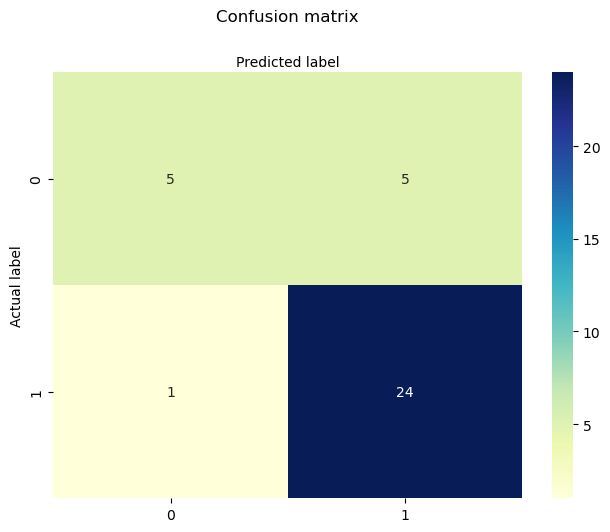

In [141]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Text(0.5,257.44,'Predicted label');

In [142]:
target_names = ["Not Placed", "Placed"]
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Not Placed       0.83      0.50      0.62        10
      Placed       0.83      0.96      0.89        25

    accuracy                           0.83        35
   macro avg       0.83      0.73      0.76        35
weighted avg       0.83      0.83      0.81        35



# Recursive Feature Elimination

In [143]:
# Use RFE with cross-validation to 
# find the optimal number of features
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
selector = RFECV(estimator, step = 1, cv=10)
selector = selector.fit(X, y)
  
# Print the optimal number of features
print("Optimal number of features: %d" % selector.n_features_)
  
# Print the selected features
print("Selected features: %s" % selector.support_)

Optimal number of features: 11
Selected features: [False  True False  True False  True False  True  True  True False  True
  True  True  True  True]


In [144]:

# Keep selected features

X_subset = X[list(X.columns[selector.support_])]

# Hyperparameters Tuning

In [150]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'min_impurity_decrease': [round(i,1) for i in np.arange(0.0,0.8,0.1)],
              'max_depth' : [i for i in range(5,31)],
              'criterion' :['gini', 'entropy']
             }
tree_clas = DecisionTreeClassifier(random_state=1024)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=10, verbose=True)
grid_search.fit(X_subset, y)

Fitting 10 folds for each of 3744 candidates, totalling 37440 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1024),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                       16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                       26, 27, 28, 29, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                   0.6, 0.7]},
             verbose=True)

In [151]:
final_model = grid_search.best_estimator_
final_model


DecisionTreeClassifier(ccp_alpha=0.01, max_depth=10, max_features='auto',
                       random_state=1024)

# Final Model Testing

Text(0.5, 427.9555555555555, 'Predicted label')

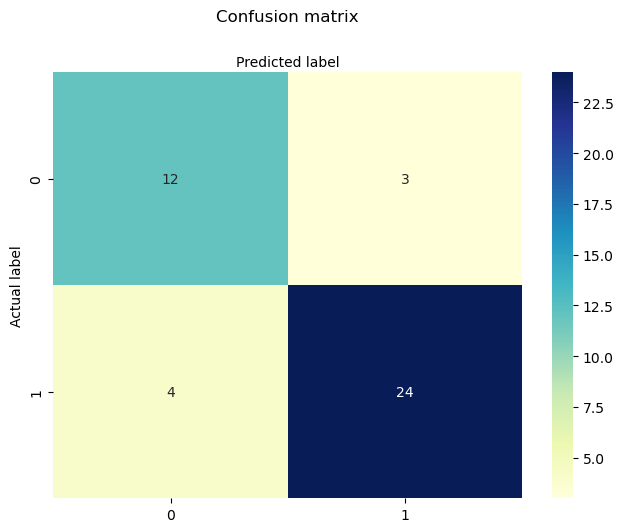

In [152]:

# fit the model with data
final_model.fit(X, y)

y_pred = final_model.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [153]:
target_names = ["Not Placed", "Placed"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Not Placed       0.75      0.80      0.77        15
      Placed       0.89      0.86      0.87        28

    accuracy                           0.84        43
   macro avg       0.82      0.83      0.82        43
weighted avg       0.84      0.84      0.84        43

